# 多項式曲線フィッティング (2)：  過学習を防ぐ「正則化」項とscikit-learn利用の暫定まとめ

<div style="text-align: right;">
    <a href="function_fitting2.ipynb">このページのオリジナルのipynbファイル</a><br/>
    <a href="index.html">Return to home page</a>
</div>

## (先週話したことの補足）

数学的な詳細の理解には時間がかかるが、

> **2乗誤差最小化問題という多変数関数の極値（最小値）問題が線形代数の（行列）計算に帰着できる**
  
ということに注目してほしい。これは評価関数が２次関数の線形結合になっている場合に限られるが、「計画行列」の活用は後のカーネル法などにも引き継がれる。

(注) 関数の極値問題は勾配法(一変数の場合はニュートン法と呼ばれる)による繰り返し計算を行うことが多い(たとえば、https://fussy.web.fc2.com/algo/math10_extreme.htm)。

多数の局所的な極小がたくさんある場合は困難であり、様々なシミュレーション的方法が行われている。


## 今週の話

"IPython Interactive Computing and Visualization Cookbook" (O'Reilly, 2018)のサンプルプログラム8.1を例に
（現在、原文はhttps://ipython-books.github.io/ にて閲覧できる。）

模式図はPRMLより。


## 2乗誤差最小化 (復習)

説明変数$x$に対する目的変数$y$について、$M$次関数でのフィッティングを考える：
$$
 y(x, {\bf w}) = w_0 + w_1 x + w_2 x^2 + \cdots + w_M x^M = \sum_{j=0}^{M} w_j x^j
$$
データ$\{(x_n, t_n)\}$ ($n=1,\cdots N$)があったときに、
2乗誤差
$$
E({\bf w}) = \frac{1}{2} \sum_{n=1}^N \{y(x_n,{\bf w}) - t_n\}^2
$$
を最小にするよう${\bf w}$を決める。



説明用に、PRMLに載っている図を載せておく。

最小２乗法の模式図：

<img src="http://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/prmlfigs-png/Figure1.3.png" width="400">


$\sin$カーブにノイズを載せたテストデータをべき関数フィッティングしてみた例：次数$M$をが大きいほうが全データにあうフィッティングができるが、不自然であることがわかるだろう。($M$が次数)
<img src="http://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/prmlfigs-png/Figure1.4a.png" width="400">
<img src="http://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/prmlfigs-png/Figure1.4b.png" width="400">
<img src="http://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/prmlfigs-png/Figure1.4c.png" width="400">
<img src="http://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/prmlfigs-png/Figure1.4d.png" width="400">

一般に高次項の係数がとても大きくなる。(前回の関数フィッティングのプログラムで係数を表示してみてほしい。function_fitting.htmlの最後のセルにあるプリント文のコメントを外せばよい。）

それを抑える工夫が次に述べるリッジ回帰、ラッソ回帰と呼ばれるものである。


## リッジ回帰とラッソ回帰

過学習を防ぐために、次のような係数に対する2次関数を付加し、その最小化を図る。この項は大きな係数の方が不利になるので、高次の項の「暴発」が抑えられる。

$$
\tilde{E}({\bf w}) = \frac{1}{2} \sum_{n=1}^N \{y(x_n,{\bf w}) - t_n\}^2 + \frac{\lambda}{2}||{\bf w}||^2
$$

これはリッジ回帰(ridge regression)を呼ばれる。ニューラルネットでは、荷重減衰(weight decay)として知られている。（下に述べるように第2項をノルムの1乗にしたものがラッソ回帰である。）

また、このことを正則化(regularization)と呼ぶ。

### リッジ回帰における重み係数

上記のPRMLの事例にある式で係数$\lambda$を固定して最小化を行った例($M=9$)：$\lambda$が大きいと加重がきつくフィッティングされにくくなる。リッジ回帰では$\lambda$を手入力で与える必要がある。（下で試すscikit-learnでは**alpha**という引数で指定）

<img src="http://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/prmlfigs-png/Figure1.7a.png" width="400">
<img src="http://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/prmlfigs-png/Figure1.7b.png" width="400">

### pythonスクリプトでの実例

#### サンプルデータの作成

まずは前回同様、サンプルデータを作っておく。 (sinカーブでなくてもよい）

ここでは、無名関数fを定義し、それにランダムデータを加える形でデータを作成してみる。


フィッティング関数の次数=2
切片= 0.29932136810589793
係数= -0.058 0.051 0.000
フィッティング関数の次数=5
切片= 1.0067129477813304
係数= 0.097 -1.184 4.823 -7.132 2.064 0.000
フィッティング関数の次数=10
切片= 0.8572252716535681
係数= -0.002 0.040 -0.327 1.367 -2.904 2.445 -0.018 2.986 -8.610 3.721 0.000


(-2.0, 2.0)

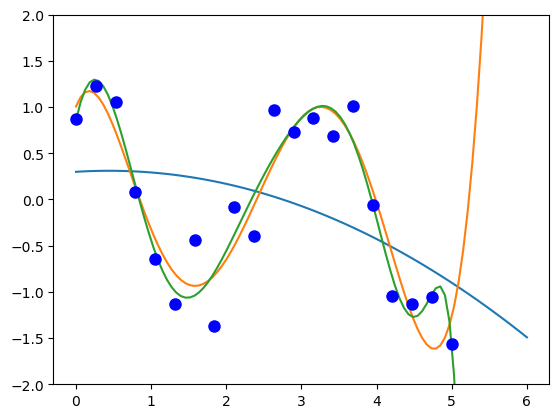

In [1]:
# 今まで試してきた多項式近似の復習
import numpy as np
import random
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

f_cos = lambda x: np.cos(2.0*x) # サンプルデータを作るためのベース関数: このような関数定義の記述方法もある

# データ数
n_tr = 20
x_max = 5.0 # xの範囲 [0, x_max]
x = np.linspace(0., x_max, n_tr)
y = f_cos(x) + np.random.randn(len(x))*0.3


# 単純な多項式近似
lrp = lm.LinearRegression()

for deg in [2,5,10]: # 最大べき
    power_matrix_x = np.vander(x, deg+1) # 計画行列の作成
    lrp.fit(power_matrix_x, y)
    # モデルの係数表示
    print('フィッティング関数の次数=' + str(deg))
    print('切片= ' + str(lrp.intercept_))
    print('係数= ' +  ' '. join(['%.3f' % c for c in lrp.coef_]))
    # 予測
    x_lrp = np.linspace(0., x_max*1.2, 100)
    y_lrp = lrp.predict(np.vander(x_lrp, deg+1))
    # 近似曲線の描画
    plt.plot(x_lrp, y_lrp)

# データの描画
plt.plot(x, y, "ob", ms=8)
plt.ylim(-2.0,2.0)

In [8]:
# (参考) 説明変数と目的変数データの一覧表示
import pandas as pd
power_matrix_x = np.vander(x, 5)
df = pd.DataFrame(power_matrix_x, columns=["x^4", "x^3", "x^2", "x^1", "x^0"])
df["y"] = y
df.head()

x^4       x^3       x^2       x^1  x^0         y
0  0.000000  0.000000  0.000000  0.000000  1.0  0.868819
1  0.004796  0.018224  0.069252  0.263158  1.0  1.226901
2  0.076734  0.145794  0.277008  0.526316  1.0  1.057635
3  0.388464  0.492054  0.623269  0.789474  1.0  0.085984
4  1.227738  1.166351  1.108033  1.052632  1.0 -0.646647

#### scikit-learnのリッジ回帰

マニュアルページ：
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html


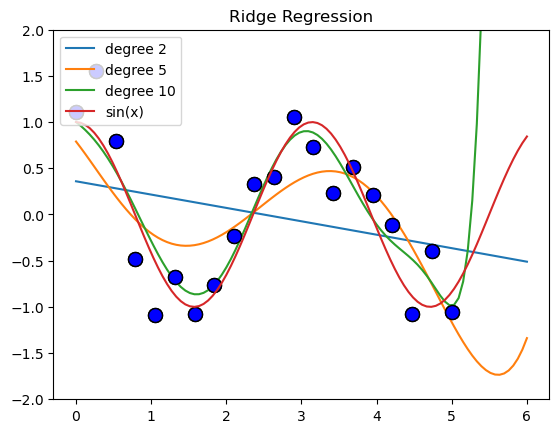

In [22]:

# リッジ回帰 alpha(正則化係数)の既定値は1.0  = 上の解説文におけるλ
ridge = lm.Ridge(alpha=1.0)

for deg in [2,5,10]: # 最大べき
    ridge.fit(np.vander(x, deg +1), y) # リッジ回帰
    # 予測
    x_lrp = np.linspace(0., x_max*1.2, 100)
    y_lrp = ridge.predict(np.vander(x_lrp, deg+1))
    plt.plot(x_lrp, y_lrp,
            label='degree ' + str(deg))
    plt.plot(x, y , 'ok', ms=10)
    plt.title('Ridge Regression')
    # モデルの係数表示
    # print('フィッティング関数の次数=' + str(deg))
    # print('切片= ' + str(ridge.intercept_))
    # print('  '. join(['%.5f' % c for c in ridge.coef_]))
    # 「真の値」cos(x)との比較による決定係数R2の算出
    # 実際には、真の値はわからない。その場合、トレーニングデータとは別にテストデータを用意し、それで検証する
    #print("alpha=" + str(alpha) + "R2=" + str(ridge.score(np.vander(x, deg+1), f_cos(x))))

# サンプルデータのプロット
plt.ylim(-2.0,2.0)
plt.plot(x, y, "ob", ms=8)
# sin curve
plt.plot(x_lrp, f_cos(x_lrp), label="sin(x)")
plt.legend(loc=2)

フィッティング関数の次数=2
切片= 0.3979034795533577
0.00772  -0.18626  0.00000
alpha=0.05, deg=2, R2=0.08099024845662606
フィッティング関数の次数=5
切片= 1.5234523909155355
0.04708  -0.53612  1.84700  -1.40814  -2.01450  0.00000
alpha=0.05, deg=5, R2=0.9173548653834334
フィッティング関数の次数=10
切片= 1.433938628006912
-0.00029  0.00699  -0.06804  0.33454  -0.80015  0.53295  0.90646  -0.29123  -1.65203  -0.99771  0.00000
alpha=0.05, deg=10, R2=0.928736566503565
フィッティング関数の次数=2
切片= 0.3952827700097704
0.00718  -0.18337  0.00000
alpha=0.1, deg=2, R2=0.08129928631178551
フィッティング関数の次数=5
切片= 1.4588184684504582
0.04219  -0.48008  1.63639  -1.14247  -2.02434  0.00000
alpha=0.1, deg=5, R2=0.9075383888157087
フィッティング関数の次数=10
切片= 1.388588243467906
0.00002  0.00081  -0.01907  0.14534  -0.46298  0.41200  0.59874  -0.24986  -1.24214  -1.10792  0.00000
alpha=0.1, deg=10, R2=0.9386575657408042
フィッティング関数の次数=2
切片= 0.385583523902594
0.00518  -0.17266  0.00000
alpha=0.3, deg=2, R2=0.082399852524357
フィッティング関数の次数=5
切片= 1.2160943117003653
0.03131  -0.

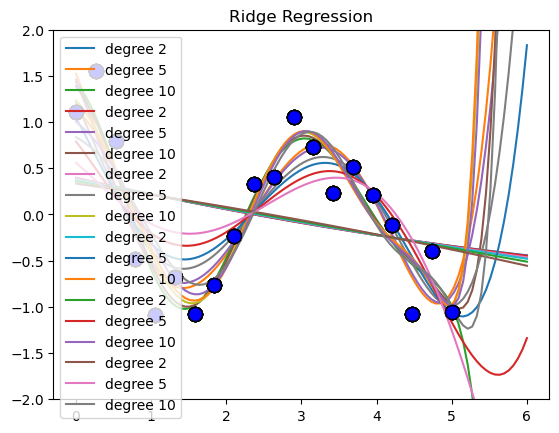

In [23]:

# リッジ回帰 alpha(正則化係数)の既定値は1.0 

for a in [0.05, 0.1, 0.3, 0.5, 1.0, 2.0]:
    ridge = lm.Ridge(alpha=a)
    
    for deg in [2, 5, 10]: # 最大べき
        ridge.fit(np.vander(x, deg +1), y) # リッジ回帰
        # 予測
        x_lrp = np.linspace(0., x_max*1.2, 100)
        y_lrp = ridge.predict(np.vander(x_lrp, deg+1))
        plt.plot(x_lrp, y_lrp,
                label='degree ' + str(deg))
        plt.legend(loc=2)
        plt.plot(x, y , 'ok', ms=10)
        plt.title('Ridge Regression')
        # モデルの係数表示
        print('フィッティング関数の次数=' + str(deg))
        print('切片= ' + str(ridge.intercept_))
        print('  '. join(['%.5f' % c for c in ridge.coef_]))
        # 「真の値」cos(x)との比較による決定係数R2の算出
        # 実際には、真の値はわからない。
        # その場合、トレーニングデータとは別にテストデータを用意し、それで検証する
        print("alpha=" + str(a) + ", deg=" + str(deg) 
              + ", R2=" + str(ridge.score(np.vander(x, deg+1), f_cos(x))))

# サンプルデータのプロット
plt.ylim(-2.0,2.0)
plt.plot(x, y, "ob", ms=8)

In [27]:
a = ("dfasdaaaaafaafdfsdfjsfjdskfas;fasfd;asdfasf;asfsdfsafsafasdsda"
     + "ddfasdfasdfasdfasdfdfdfas")

'''
コメント
'''

#### Lasso回帰

ウェイトの項を単に絶対値$\frac{\lambda}{2}||{\bf w}||$にしたものをlasso回帰と呼ぶ。


In [ ]:
model = lm.Lasso(alpha=0.01)
for deg in [2,5,10]: # 最大べき
    model.fit(np.vander(x, deg +1), y) # リッジ回帰
    # 予測
    x_lrp = np.linspace(0., x_max*1.2, 100)
    y_lrp = model.predict(np.vander(x_lrp, deg+1))
    plt.plot(x_lrp, y_lrp,
            label='degree ' + str(deg))
    plt.legend(loc=2)
    # モデルの係数表示
    # モデルの係数表示
    print('フィッティング関数の次数=' + str(deg))
    print('切片= ' + str(lrp.intercept_))
    print('係数' + ' '. join(['%.5f' % c for c in model.coef_]))
    plt.plot(x, y , 'ok', ms=10)
    plt.title('Lasso Regression')

# サンプルデータのプロット
plt.ylim(-2.0,2.0)
plt.plot(x, y, "ob", ms=8)

Lassoの場合、この程度のばらつきの場合だと、既定の加重係数(alpha=1.0)は大きすぎるようだ。また、データ数を多くしないと収束がわるという警告がでる。


全体として、次数を上げた場合、加重を含む最適化を行っているため、過学習が抑えられている。

係数alpha (上の式では$\lambda$)は外からあたえるパラメータであり、**ハイパーパラメータ**と呼ばれる。

### Exercise 3

- データ作成のベース関数やデータ数、ハイパーパラメータ(正則化係数alphaやフィッティング関数の次数)を変えて振る舞いを確かめてみよう。
- ランダム項を含まないcos(x)を再現(推定)できているかを決定係数R2を用いて評価してみよう。

(注) 決定係数

テストデータの実測値を$(t_1, t_2, \cdots, t_N)$、予測(推定)値を$(y_1, y_2, \cdots, y_N)$としたとき

$$
R^2 = 1 - \frac{\sum_{i=1}^N (y_i - t_i)^2}{ \sum_{i=1}^N (t_i - \bar{t})^2}
$$


## scikit-learnの利用まとめ Summary on the scikit-learn fitting libraries

The regression problem we solve (predict) is to make a numerical machine that predict the value $y$ from the explanation variables $\{\boldsymbol{x}\}$ from a training dataset $\{\boldsymbol{x}_n, y\}$.

$$
y = f(\{\boldsymbol{x}_n\}, \boldsymbol{x})
$$
where the values of the dataset is regarded as parameters of $f(\boldsymbol{x})$.

- Select a model xxxxx (one of linear, Ridge, Lasso, support vector machine, neural net, and etc)
  ```python
  import sklearn.linear_model as lm
  model = lm.xxxxxx(parameter1, parameter2, ....)
  ```
- Prepare a training dataset: array "x" of explanation variables and list of target "y"
  
- Train the machine by the dataset
  ```python
  model.fit(x,y, ....)
  ```
  
- Predict $y$ from a set of explanation variables $\{x_1, x_2, \cdots \}$.
  ```python
  model.predict(x)
  ```

## 補足 : 外れ値について

極端な外れ値を含む場合は、別の対応が必要である。

参考：scikit-learnの事例より

https://scikit-learn.org/stable/auto_examples/linear_model/plot_huber_vs_ridge.html#sphx-glr-auto-examples-linear-model-plot-huber-vs-ridge-py


In [24]:
# Authors: Manoj Kumar mks542@nyu.edu
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.linear_model import HuberRegressor, Ridge

def huber_vs_ridge(show_ridge=True, show_huber=True):
    # Generate toy data.
    rng = np.random.RandomState(0)
    X, y = make_regression(
        n_samples=20, n_features=1, random_state=0, noise=4.0, bias=100.0
    )
    
    # Add four strong outliers to the dataset.
    X_outliers = rng.normal(0, 0.5, size=(4, 1))
    y_outliers = rng.normal(0, 2.0, size=4)
    X_outliers[:2, :] += X.max() + X.mean() / 4.0
    X_outliers[2:, :] += X.min() - X.mean() / 4.0
    y_outliers[:2] += y.min() - y.mean() / 4.0
    y_outliers[2:] += y.max() + y.mean() / 4.0
    X = np.vstack((X, X_outliers))
    y = np.concatenate((y, y_outliers))
    plt.plot(X, y, "b.")
    x = np.linspace(X.min(), X.max(), 7)
    
    # Fit the huber regressor over a series of epsilon values.
    if show_huber:
        colors = ["r-", "b-", "y-", "m-"]
        epsilon_values = [1, 1.5, 1.75, 1.9]
        for k, epsilon in enumerate(epsilon_values):
            huber = HuberRegressor(alpha=0.0, epsilon=epsilon)
            huber.fit(X, y)
            coef_ = huber.coef_ * x + huber.intercept_
            plt.plot(x, coef_, colors[k], label="huber loss, %s" % epsilon)
    
    # Fit a ridge regressor to compare it to huber regressor.
    if show_ridge:
        ridge = Ridge(alpha=0.0, random_state=0)
        ridge.fit(X, y)
        coef_ridge = ridge.coef_
        coef_ = ridge.coef_ * x + ridge.intercept_
        plt.plot(x, coef_, "g-", label="ridge regression")
    
    plt.title("Comparison of HuberRegressor vs Ridge")
    plt.xlabel("X")
    plt.ylabel("y")
    if show_ridge or show_huber:
        plt.legend(loc=0)
    plt.show()

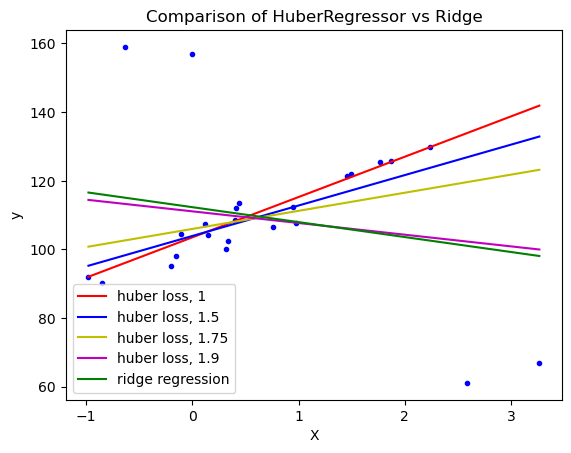

In [19]:
huber_vs_ridge()

In [25]:
# Using "interact" to switch on or off showing results of two kind of regressions 

from ipywidgets import interact
interact(huber_vs_ridge, show_ridge=False, show_huber=False)


interactive(children=(Checkbox(value=False, description='show_ridge'), Checkbox(value=False, description='show…

<function __main__.huber_vs_ridge(show_ridge=True, show_huber=True)>

In [20]:
%%html
<link rel="stylesheet" type="text/css" href="custom.css">